In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [42]:
import pandas as pd
import numpy as np

# Load train and test data
train_file = './Train_data.csv'
test_file = './Test_data.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

# Extract embeddings
train_embeddings = np.vstack(train_df['Embeddings'].apply(eval).to_numpy())
test_embeddings = np.vstack(test_df['Embeddings'].apply(eval).to_numpy())

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")


Train embeddings shape: (16158, 384)
Test embeddings shape: (20142, 384)


In [6]:
from tensorflow.keras import layers, models

# Define dimensions
input_dim = train_embeddings.shape[1]  # 384
encoding_dim = 128  # You can tune this for the bottleneck size

# Build the autoencoder
autoencoder = models.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),  # Corrected: input_shape as a tuple
    layers.Dense(256, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),  # Bottleneck layer
    layers.Dense(256, activation='relu'),
    layers.Dense(input_dim, activation='linear')  # Output layer matches input dimension
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


/Users/oscarcanning-thompson/mdm3_phaseB/new_env_name/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 384)            │        98,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,168 (1.00 MB)

 Trainable params: 263,168 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = autoencoder.fit(
    train_embeddings, train_embeddings,  # Input = Output for autoencoders
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3436e-04 - val_loss: 1.2741e-05
Epoch 2/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2542e-05 - val_loss: 1.2303e-05
Epoch 3/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2054e-05 - val_loss: 1.0994e-05
Epoch 4/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0736e-05 - val_loss: 9.6411e-06
Epoch 5/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5869e-06 - val_loss: 8.6970e-06
Epoch 6/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5950e-06 - val_loss: 7.9079e-06
Epoch 7/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7758e-06 - val_loss: 7.3243e-06
Epoch 8/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2962e-06 - val_loss: 6.8729e-06
Epoch 9/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6562e-06 - val_loss: 6.4434e-06
Epoch 10/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2531e-06 - val_loss: 6.1572e-06
Epoch 11/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss

In [8]:
# Reconstruct test embeddings
reconstructions = autoencoder.predict(test_embeddings)

# Compute Mean Squared Errors (MSE) for each test embedding
mse = np.mean(np.square(test_embeddings - reconstructions), axis=1)

# Print MSE for inspection
print("Mean Squared Errors (MSE):")
print(mse)


630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
Mean Squared Errors (MSE):
[2.96524866e-06 1.24796984e-05 4.64277668e-06 ... 3.47128142e-06
 1.75489338e-05 1.40512069e-05]


In [9]:
# Calculate reconstruction errors for train data
train_reconstructions = autoencoder.predict(train_embeddings)
train_mse = np.mean(np.square(train_embeddings - train_reconstructions), axis=1)

# Set anomaly threshold
threshold = np.percentile(train_mse, 95)  # Use 95th percentile as the threshold

print(f"Anomaly Threshold: {threshold}")


505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
Anomaly Threshold: 5.749841642276529e-06


In [10]:
# Identify anomalies in the test data
anomalies = mse > threshold

print(f"Number of Anomalies: {np.sum(anomalies)}")

# Add results to the test DataFrame
test_df['Reconstruction Error'] = mse
test_df['Anomaly'] = anomalies


Number of Anomalies: 5336


In [32]:
# Assuming Chunk IDs are sequentially aligned with the test embeddings
chunk_ids = np.arange(len(mse))  # Generate Chunk IDs (0 to len(mse) - 1)
print(len(chunk_ids))
print(len(chunk_labels))
# Create a DataFrame with Chunk ID and Reconstruction Error
reconstruction_results = pd.DataFrame({
    'Chunk ID': chunk_ids,
    'Reconstruction Error': mse
})

# Save reconstruction results for later use (optional)
reconstruction_results.to_csv('./reconstruction_errors.csv', index=False)
print("Reconstruction results saved to reconstruction_errors.csv")


20142
20142
Reconstruction results saved to reconstruction_errors.csv


In [34]:
# File path for the test labels
chunk_labels_path = './Test_summaries_with_labels.csv'

# Load the chunk labels
chunk_labels = pd.read_csv(chunk_labels_path)
print(chunk_labels.head())  # Verify the loaded data
 

    Chunk ID                                            Summary Chunk Label
0  759544200  The chunk contains a total of 1668 packets and...      Benign
1  759544201  The chunk contains a total of 1850 packets and...      Benign
2  759544202  The chunk contains a total of 7202 packets and...      Benign
3  759544203  The chunk contains a total of 5435 packets and...      Benign
4  759544204  The chunk contains a total of 12569 packets an...      Benign


In [35]:
print(reconstruction_results.head())

   Chunk ID  Reconstruction Error
0         0              0.000003
1         1              0.000012
2         2              0.000005
3         3              0.000007
4         4              0.000005


In [36]:
 #Reset the Chunk ID in reconstruction_results to align with test_labels
reconstruction_results['Chunk ID'] = test_labels['Chunk ID'].values  # Remap IDs


In [38]:
# Merge the datasets
merged_df = pd.merge(reconstruction_results, test_labels, on='Chunk ID', how='inner')

# Inspect the merged DataFrame
print(merged_df.head())


    Chunk ID  Reconstruction Error  \
0  759544200              0.000003   
1  759544201              0.000012   
2  759544202              0.000005   
3  759544203              0.000007   
4  759544204              0.000005   

                                             Summary Chunk Label  
0  The chunk contains a total of 1668 packets and...      Benign  
1  The chunk contains a total of 1850 packets and...      Benign  
2  The chunk contains a total of 7202 packets and...      Benign  
3  The chunk contains a total of 5435 packets and...      Benign  
4  The chunk contains a total of 12569 packets an...      Benign  


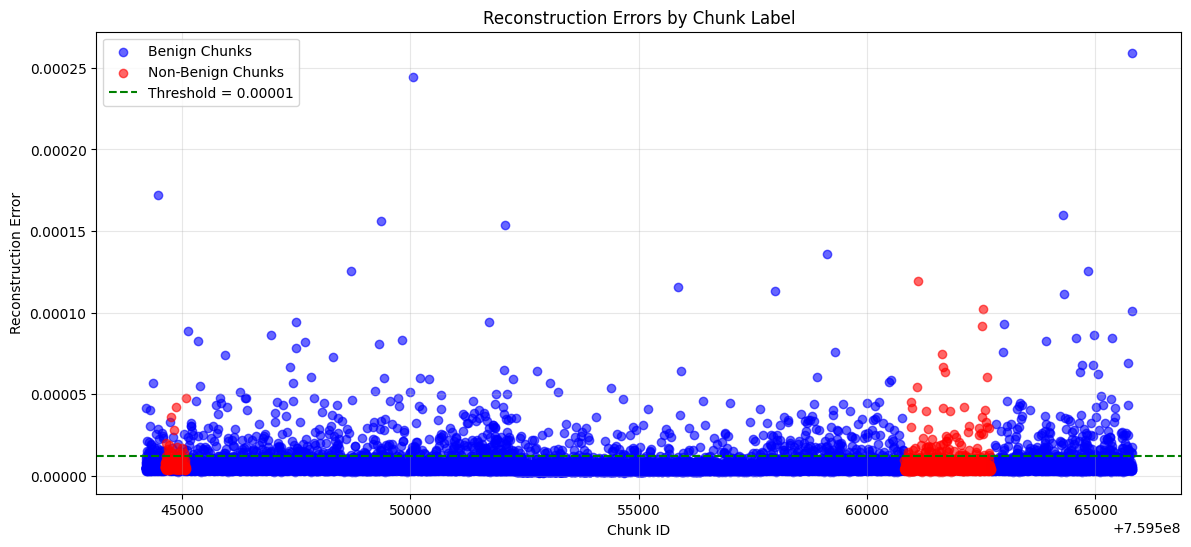

In [39]:
import matplotlib.pyplot as plt

# Separate benign and non-benign chunks
benign_chunks = merged_df[merged_df['Chunk Label'] == 'Benign']
non_benign_chunks = merged_df[merged_df['Chunk Label'] != 'Benign']

# Plot reconstruction errors
plt.figure(figsize=(14, 6))
plt.scatter(benign_chunks['Chunk ID'], benign_chunks['Reconstruction Error'], color='blue', alpha=0.6, label='Benign Chunks')
plt.scatter(non_benign_chunks['Chunk ID'], non_benign_chunks['Reconstruction Error'], color='red', alpha=0.6, label='Non-Benign Chunks')

# Add anomaly threshold
threshold = np.percentile(reconstruction_results['Reconstruction Error'], 95)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold:.5f}')

# Configure plot
plt.title('Reconstruction Errors by Chunk Label')
plt.xlabel('Chunk ID')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [37]:
print(reconstruction_results.head())

    Chunk ID  Reconstruction Error
0  759544200              0.000003
1  759544201              0.000012
2  759544202              0.000005
3  759544203              0.000007
4  759544204              0.000005


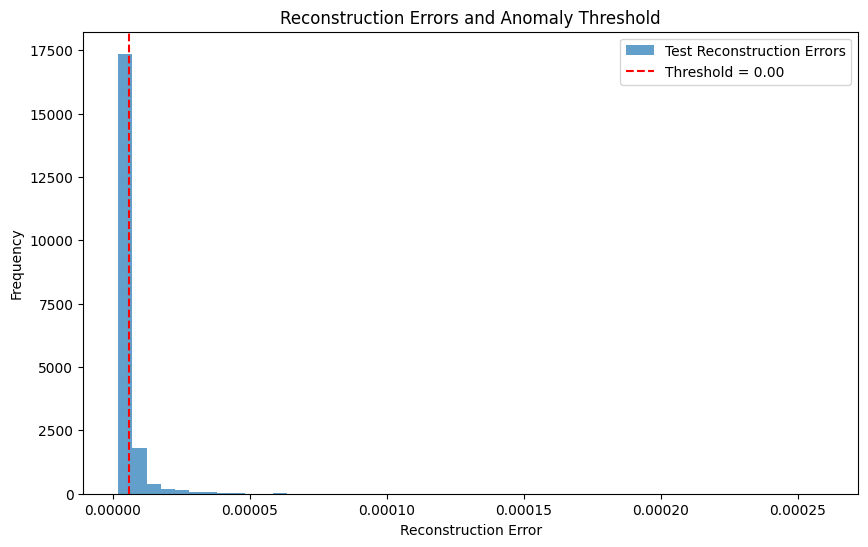

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.7, label="Test Reconstruction Errors")
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Reconstruction Errors and Anomaly Threshold")
plt.show()


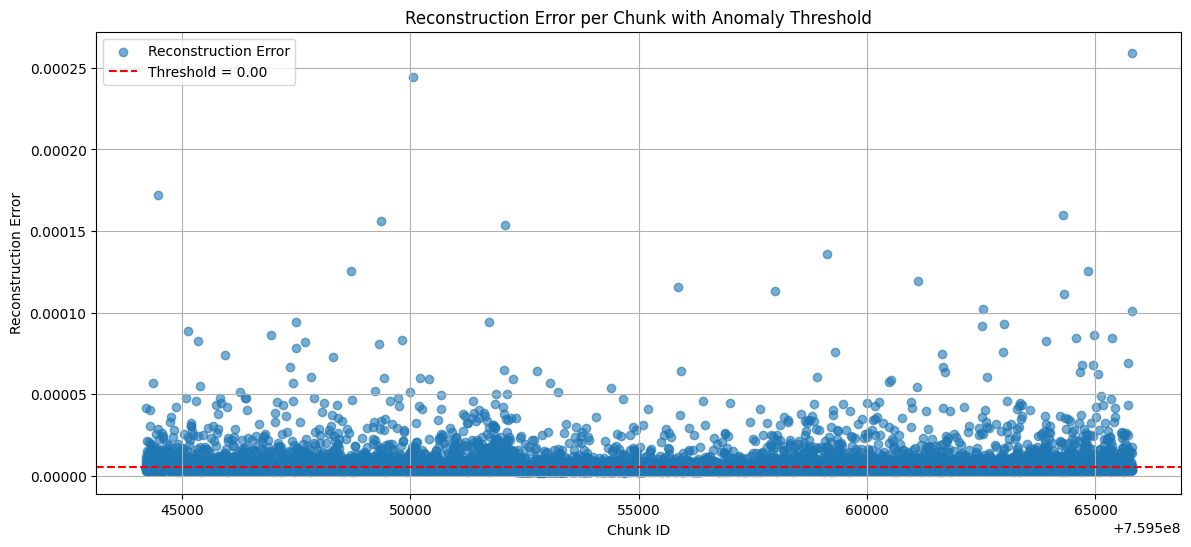

In [12]:
import matplotlib.pyplot as plt

# Sort chunks by their IDs for better visualization
test_df = test_df.sort_values(by='Chunk ID')

# Plot the reconstruction errors
plt.figure(figsize=(14, 6))
plt.scatter(test_df['Chunk ID'], test_df['Reconstruction Error'], label='Reconstruction Error', alpha=0.6)
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xlabel("Chunk ID")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error per Chunk with Anomaly Threshold")
plt.legend()
plt.grid(True)
plt.show()


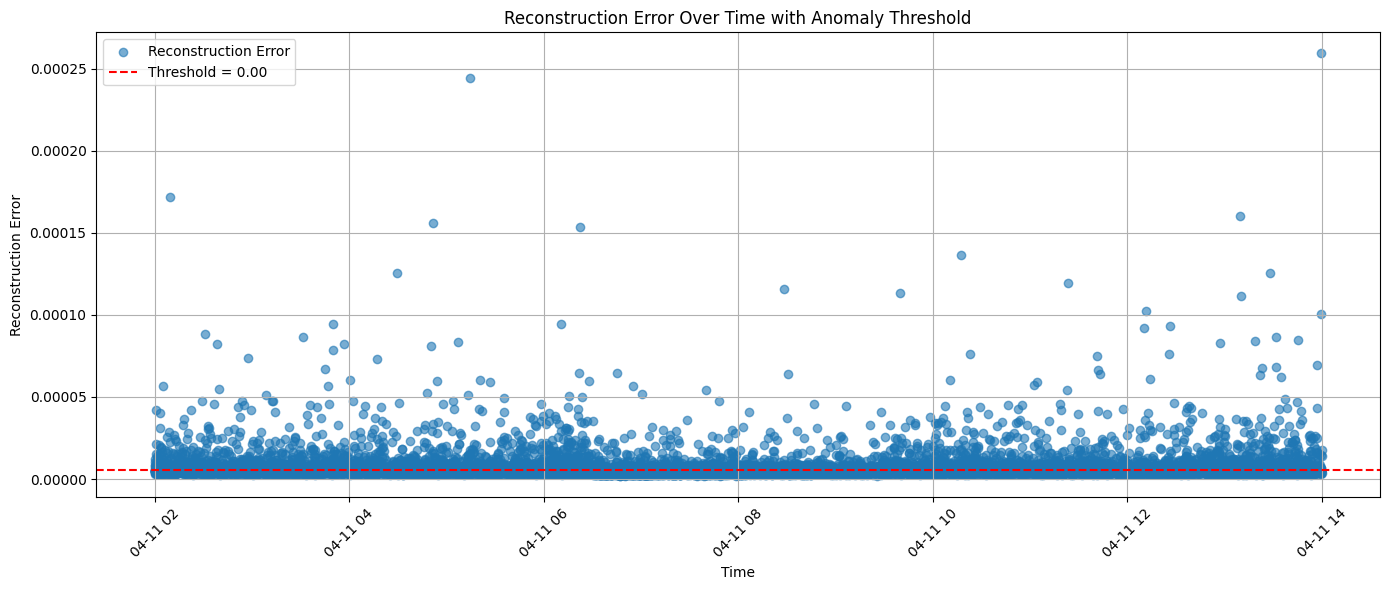

In [14]:
import matplotlib.pyplot as plt

# Sort the DataFrame by Chunk ID
test_df = test_df.sort_values(by='Chunk ID')

# Get the reference start time (earliest timestamp in your dataset)
reference_start_time = data['Timestamp'].min()

# Convert Chunk ID to actual start time of each chunk
test_df['Chunk Time'] = reference_start_time + pd.to_timedelta(test_df['Chunk ID'] * 2, unit='s')

# Plot the reconstruction errors with time on the x-axis
plt.figure(figsize=(14, 6))
plt.scatter(test_df['Chunk Time'], test_df['Reconstruction Error'], label='Reconstruction Error', alpha=0.6)
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xlabel("Time")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error Over Time with Anomaly Threshold")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


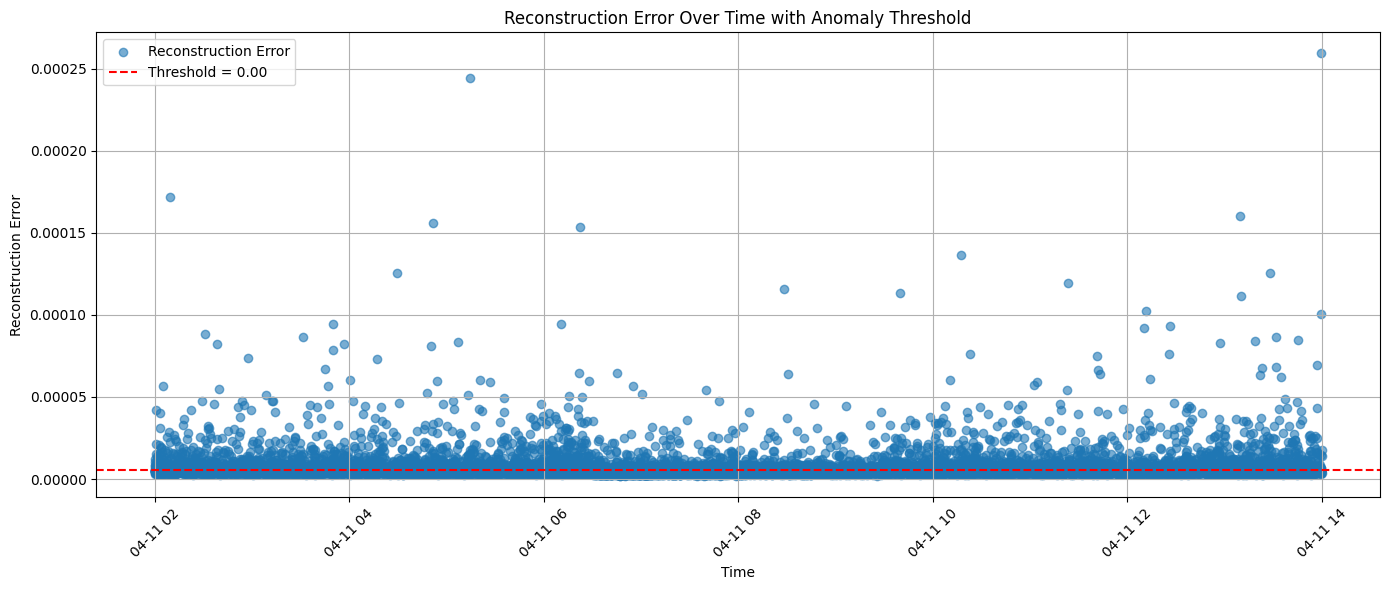

In [15]:
# Plot reconstruction errors with time on the x-axis
plt.figure(figsize=(14, 6))
plt.scatter(test_df['Chunk Time'], test_df['Reconstruction Error'], label='Reconstruction Error', alpha=0.6)
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xlabel("Time")  # Label for x-axis
plt.ylabel("Reconstruction Error")  # Label for y-axis
plt.title("Reconstruction Error Over Time with Anomaly Threshold")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


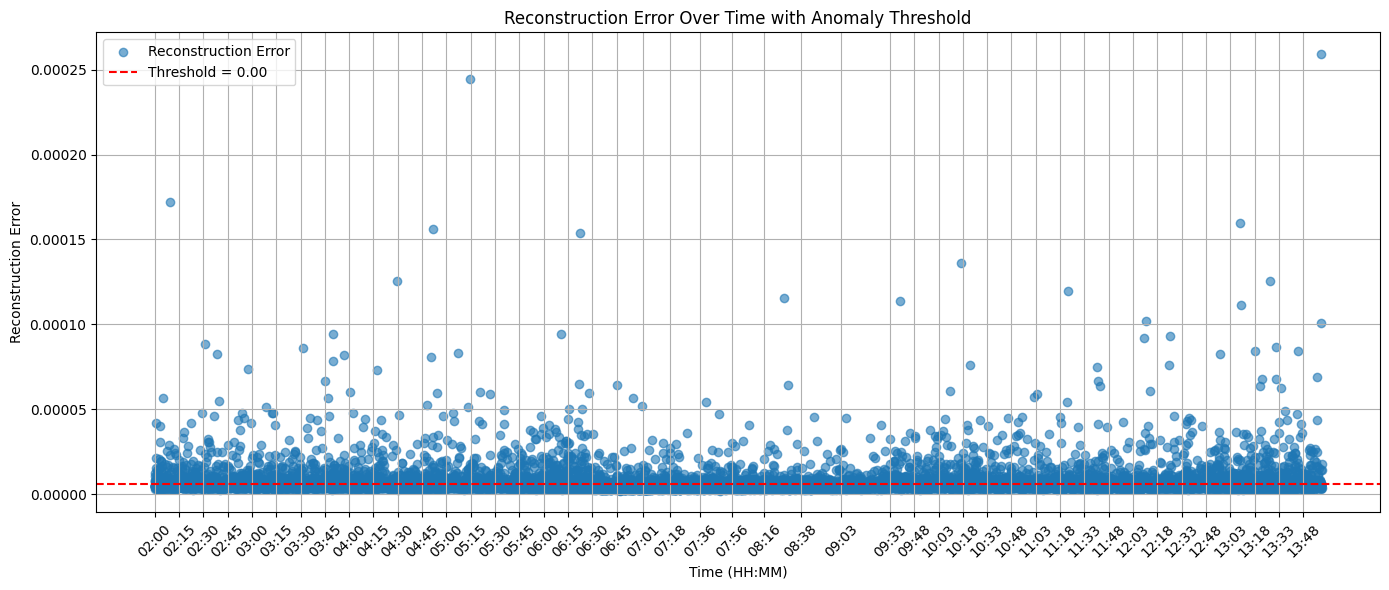

In [16]:
import matplotlib.pyplot as plt

# Ensure test_df is sorted by Chunk ID
test_df = test_df.sort_values(by='Chunk ID')

# Calculate the actual start time for each chunk
test_df['Chunk Time'] = reference_start_time + pd.to_timedelta(test_df['Chunk ID'] * 2, unit='s')

# Set up 15-minute intervals for the x-axis
time_ticks = test_df['Chunk Time'][::(15 * 60) // 2]  # Every 15 minutes (15*60 seconds / 2-second chunks)
time_labels = time_ticks.dt.strftime('%H:%M')  # Format as HH:MM

# Plot reconstruction errors with time on the x-axis
plt.figure(figsize=(14, 6))
plt.scatter(test_df['Chunk Time'], test_df['Reconstruction Error'], label='Reconstruction Error', alpha=0.6)
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xticks(time_ticks, time_labels, rotation=45)  # Apply 15-minute intervals and rotate labels
plt.xlabel("Time (HH:MM)")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error Over Time with Anomaly Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# Path to the CSV file with Chunk Labels
labels_file = './Test_summaries_with_labels.csv'  # Update this path if needed
chunk_labels = pd.read_csv(labels_file)

# Ensure 'Chunk ID' and 'Chunk Label' exist
print(chunk_labels.head())


    Chunk ID                                            Summary Chunk Label
0  759544200  The chunk contains a total of 1668 packets and...      Benign
1  759544201  The chunk contains a total of 1850 packets and...      Benign
2  759544202  The chunk contains a total of 7202 packets and...      Benign
3  759544203  The chunk contains a total of 5435 packets and...      Benign
4  759544204  The chunk contains a total of 12569 packets an...      Benign


In [3]:
# Calculate reconstruction errors for test data
test_reconstructions = autoencoder.predict(test_embeddings)
test_mse = np.mean(np.square(test_embeddings - test_reconstructions), axis=1)

# Add reconstruction errors to test_df
test_df = pd.DataFrame({
    'Chunk ID': np.arange(len(test_mse)),  # Assuming each test embedding corresponds to a chunk
    'Reconstruction Error': test_mse
})


NameError: name 'autoencoder' is not defined

In [19]:
# Merge chunk labels with reconstruction errors
test_df = test_df.merge(chunk_labels[['Chunk ID', 'Chunk Label']], on='Chunk ID', how='left')

# Replace missing labels with 'Benign' (if any chunks are missing labels)
test_df['Chunk Label'] = test_df['Chunk Label'].fillna('Benign')


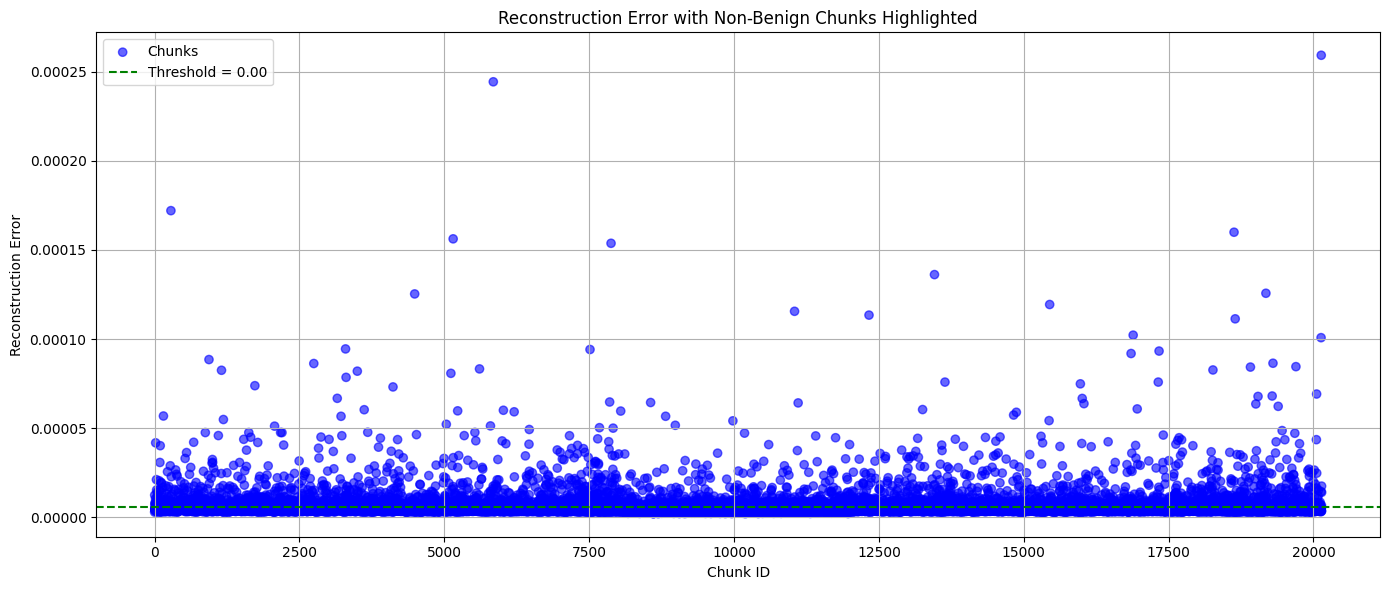

In [20]:
import matplotlib.pyplot as plt

# Define colors for benign and attack chunks
colors = ['red' if label != 'Benign' else 'blue' for label in test_df['Chunk Label']]

# Plot reconstruction errors
plt.figure(figsize=(14, 6))
plt.scatter(test_df['Chunk ID'], test_df['Reconstruction Error'], c=colors, alpha=0.6, label='Chunks')
plt.axhline(y=threshold, color='green', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xlabel("Chunk ID")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error with Non-Benign Chunks Highlighted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
print(test_df['Chunk Label'].value_counts())


Chunk Label
Benign    20142
Name: count, dtype: int64


In [23]:
test_labels = pd.read_csv('./Test_summaries_with_labels.csv')
print(test_labels.columns)


Index(['Chunk ID', 'Summary', 'Chunk Label'], dtype='object')


In [25]:
print(merged_df.columns)


Index(['Chunk ID', 'Reconstruction Error', 'Chunk Label_x', 'Summary',
       'Chunk Label_y'],
      dtype='object')


In [26]:
print(merged_df[['Chunk Label_x', 'Chunk Label_y']].head())


Empty DataFrame
Columns: [Chunk Label_x, Chunk Label_y]
Index: []


In [27]:
print("Chunk IDs in test_df:", test_df['Chunk ID'].unique())
print("Chunk IDs in test_labels:", test_labels['Chunk ID'].unique())


Chunk IDs in test_df: [    0     1     2 ... 20139 20140 20141]
Chunk IDs in test_labels: [759544200 759544201 759544202 ... 759565797 759565798 759565799]


In [26]:
from tensorflow.keras import models, layers, optimizers

# Define the dimensions
input_dim = test_embeddings.shape[1]  # Input size from embeddings
encoding_dim = 8  # Smaller bottleneck for testing a more compact latent space

# Build the updated autoencoder
autoencoder = models.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),  # Correctly specify input shape
    layers.Dense(512, activation='relu'),  # Wider first layer
    layers.BatchNormalization(),          # Normalize activations
    layers.Dropout(0.3),                  # Dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(encoding_dim, activation='relu'),  # Bottleneck layer
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dense(input_dim, activation='linear')  # Output matches input
])

# Compile the new model
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')

# Print the model summary
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(
    train_embeddings,
    train_embeddings,
    epochs=50,  # Increase if needed
    batch_size=128,
    validation_split=0.1,  # 20% validation
    verbose=2
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 512)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 384)            │       196,992 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,880 (1.77 MB)

 Trainable params: 462,600 (1.76 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/50
114/114 - 2s - 21ms/step - loss: 0.0192 - val_loss: 3.9913e-04
Epoch 2/50
114/114 - 1s - 6ms/step - loss: 0.0010 - val_loss: 2.4771e-05
Epoch 3/50
114/114 - 1s - 6ms/step - loss: 2.8744e-04 - val_loss: 1.5514e-05
Epoch 4/50
114/114 - 1s - 6ms/step - loss: 1.3437e-04 - val_loss: 1.3916e-05
Epoch 5/50
114/114 - 1s - 6ms/step - loss: 7.7697e-05 - val_loss: 1.3926e-05
Epoch 6/50
114/114 - 1s - 6ms/step - loss: 5.3834e-05 - val_loss: 1.3524e-05
Epoch 7/50
114/114 - 1s - 6ms/step - loss: 4.0131e-05 - val_loss: 1.2408e-05
Epoch 8/50
114/114 - 1s - 6ms/step - loss: 3.2523e-05 - val_loss: 1.3167e-05
Epoch 9/50
114/114 - 1s - 6ms/step - loss: 2.8812e-05 - val_loss: 1.2259e-05
Epoch 10/50
114/114 - 1s - 6ms/step - loss: 2.4601e-05 - val_loss: 1.2667e-05
Epoch 11/50
114/114 - 1s - 6ms/step - loss: 2.1957e-05 - val_loss: 1.2009e-05
Epoch 12/50
114/114 - 1s - 6ms/step - loss: 2.0641e-05 - val_loss: 1.2665e-05
Epoch 13/50
114/114 - 1s - 9ms/step - loss: 2.0218e-05 - val_loss: 1.1753e-05
Ep

In [43]:
# Reconstruct test embeddings
reconstructions = autoencoder.predict(test_embeddings)

# Compute Mean Squared Errors (MSE) for each test embedding
mse = np.mean(np.square(test_embeddings - reconstructions), axis=1)

# Print MSE for inspection
print("Mean Squared Errors (MSE):")
print(mse)

# Set a new anomaly detection threshold (e.g., 95th percentile of training MSE)
threshold = np.percentile(mse, 95)
print(f"Anomaly Threshold: {threshold}")


630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step
Mean Squared Errors (MSE):
[1.13252747e-05 3.51904440e-05 1.34890537e-05 ... 1.59962491e-05
 3.65959010e-05 3.64412292e-05]
Anomaly Threshold: 4.0780070660678574e-05


In [41]:
print("Shape of test_embeddings:", test_embeddings.shape)
print("Expected input shape for the autoencoder:", autoencoder.input_shape)


Shape of test_embeddings: (50, 128)
Expected input shape for the autoencoder: (None, 384)


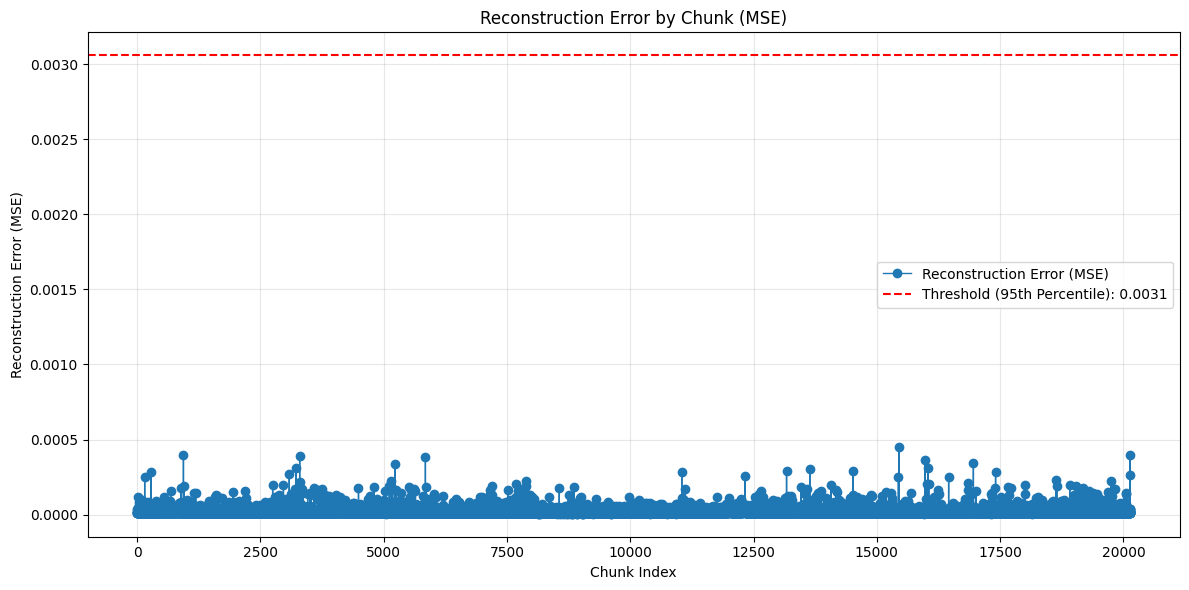

In [44]:
# Plot MSE
plt.figure(figsize=(12, 6))
plt.plot(range(len(mse)), mse, marker='o', label="Reconstruction Error (MSE)", linestyle='-', linewidth=1)
plt.axhline(y=mse_threshold, color='r', linestyle='--', label=f"Threshold (95th Percentile): {mse_threshold:.4f}")
plt.title("Reconstruction Error by Chunk (MSE)")
plt.xlabel("Chunk Index")
plt.ylabel("Reconstruction Error (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

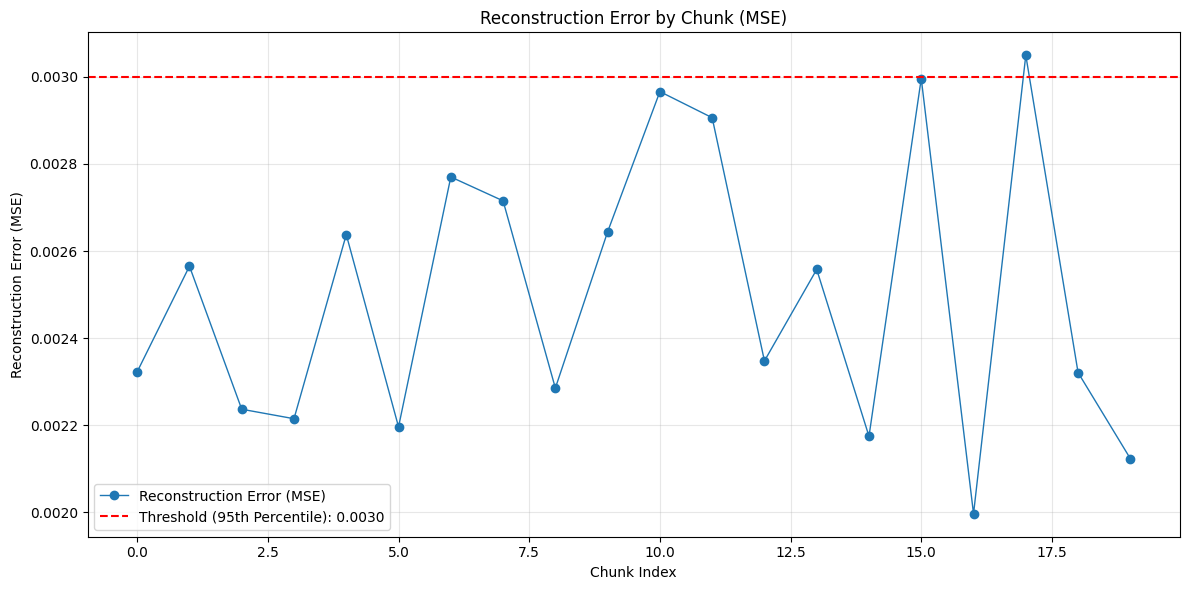

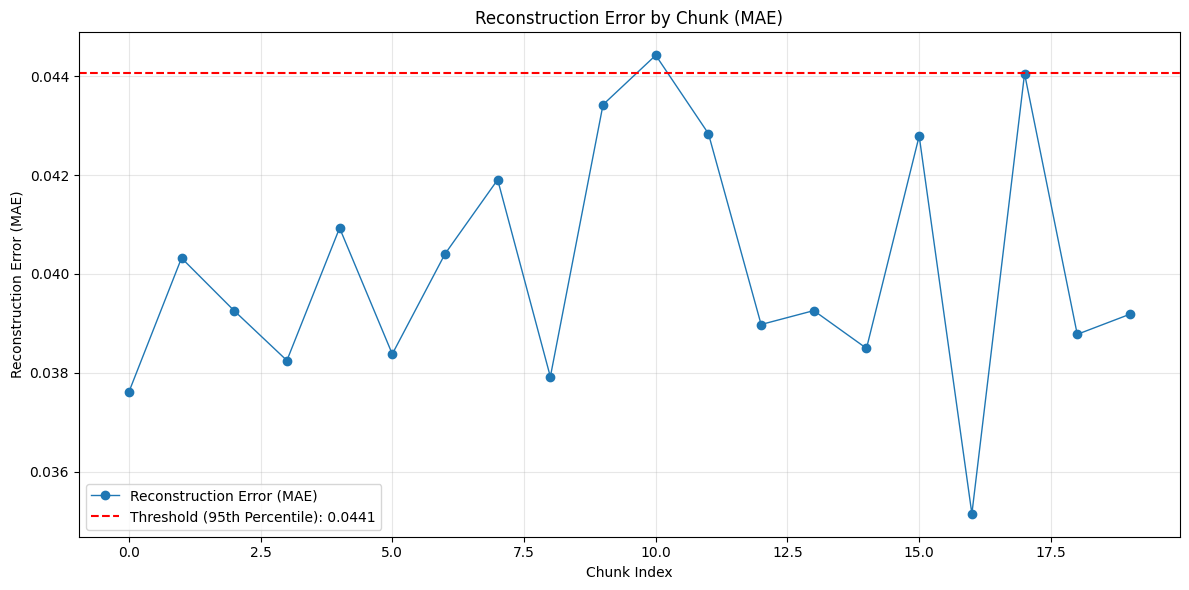

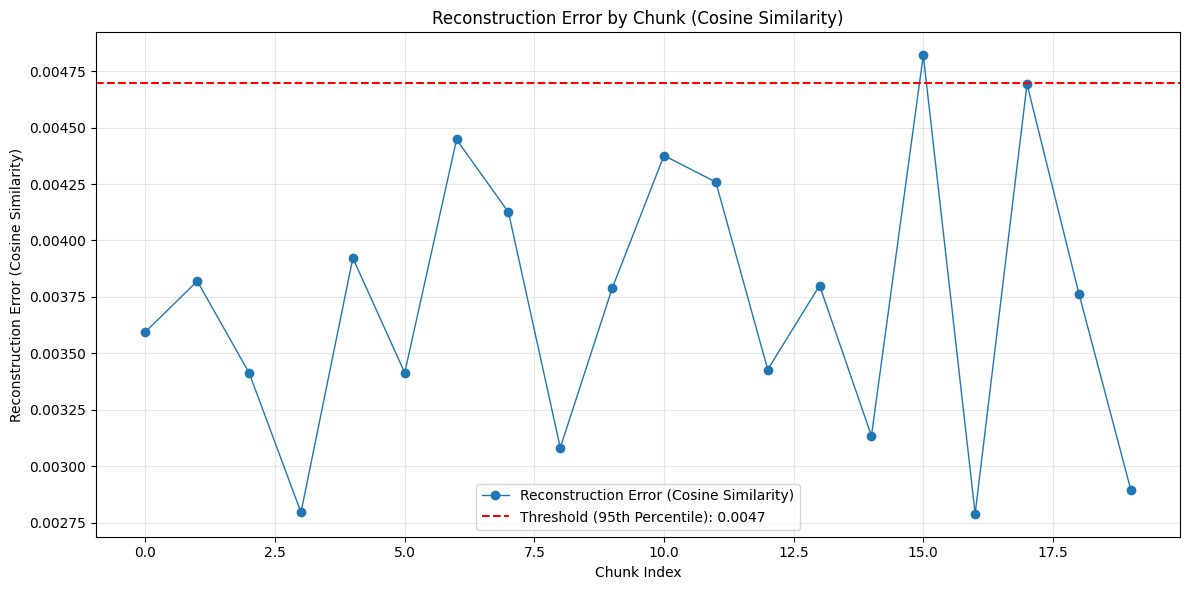

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Example test_embeddings and reconstructions for demonstration
# Replace these arrays with your actual test_embeddings and reconstructions
np.random.seed(42)  # For reproducibility
num_chunks = 20
test_embeddings = np.random.rand(num_chunks, 128)
reconstructions = test_embeddings + np.random.normal(0, 0.05, test_embeddings.shape)

# Compute Mean Squared Errors (MSE)
mse = np.mean(np.square(test_embeddings - reconstructions), axis=1)

# Compute Mean Absolute Errors (MAE)
mae = np.mean(np.abs(test_embeddings - reconstructions), axis=1)

# Compute Cosine Similarity Error
cosine_errors = 1 - cosine_similarity(test_embeddings, reconstructions).diagonal()

# Calculate anomaly detection thresholds (95th percentile)
mse_threshold = np.percentile(mse, 95)
mae_threshold = np.percentile(mae, 95)
cosine_threshold = np.percentile(cosine_errors, 95)

# Plot MSE
plt.figure(figsize=(12, 6))
plt.plot(range(len(mse)), mse, marker='o', label="Reconstruction Error (MSE)", linestyle='-', linewidth=1)
plt.axhline(y=mse_threshold, color='r', linestyle='--', label=f"Threshold (95th Percentile): {mse_threshold:.4f}")
plt.title("Reconstruction Error by Chunk (MSE)")
plt.xlabel("Chunk Index")
plt.ylabel("Reconstruction Error (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(12, 6))
plt.plot(range(len(mae)), mae, marker='o', label="Reconstruction Error (MAE)", linestyle='-', linewidth=1)
plt.axhline(y=mae_threshold, color='r', linestyle='--', label=f"Threshold (95th Percentile): {mae_threshold:.4f}")
plt.title("Reconstruction Error by Chunk (MAE)")
plt.xlabel("Chunk Index")
plt.ylabel("Reconstruction Error (MAE)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Cosine Similarity Error
plt.figure(figsize=(12, 6))
plt.plot(range(len(cosine_errors)), cosine_errors, marker='o', label="Reconstruction Error (Cosine Similarity)", linestyle='-', linewidth=1)
plt.axhline(y=cosine_threshold, color='r', linestyle='--', label=f"Threshold (95th Percentile): {cosine_threshold:.4f}")
plt.title("Reconstruction Error by Chunk (Cosine Similarity)")
plt.xlabel("Chunk Index")
plt.ylabel("Reconstruction Error (Cosine Similarity)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Check the head of test_results


# Load test summaries with labels
test_labels = pd.read_csv('./Test_summaries_with_labels.csv')

# Check the head of test_labels
print("\nHead of test_labels:")
print(test_labels.head())



Head of test_labels:
    Chunk ID                                            Summary Chunk Label
0  759544200  The chunk contains a total of 1668 packets and...      Benign
1  759544201  The chunk contains a total of 1850 packets and...      Benign
2  759544202  The chunk contains a total of 7202 packets and...      Benign
3  759544203  The chunk contains a total of 5435 packets and...      Benign
4  759544204  The chunk contains a total of 12569 packets an...      Benign


In [13]:
# Ensure both DataFrames have the same number of rows
if len(test_results) != len(test_labels):
    raise ValueError("Mismatch in the number of rows between test_results and test_labels.")

# Replace Chunk IDs in test_results with those from test_labels
test_results['Chunk ID'] = test_labels['Chunk ID'].values

# Verify the change
print("Updated test_results with new Chunk IDs:")
print(test_results.head())


NameError: name 'test_results' is not defined

In [18]:
# Merge test_results with test_labels on Chunk ID
merged_df = pd.merge(test_results, test_labels, on='Chunk ID', how='inner')

# Verify the merge
print("Merged DataFrame:")
print(merged_df.head())


Merged DataFrame:
    Chunk ID  Reconstruction Error  Anomaly  \
0  759544200              0.000011    False   
1  759544201              0.000035     True   
2  759544202              0.000013    False   
3  759544203              0.000024     True   
4  759544204              0.000018    False   

                                             Summary Chunk Label  
0  The chunk contains a total of 1668 packets and...      Benign  
1  The chunk contains a total of 1850 packets and...      Benign  
2  The chunk contains a total of 7202 packets and...      Benign  
3  The chunk contains a total of 5435 packets and...      Benign  
4  The chunk contains a total of 12569 packets an...      Benign  


In [9]:
import matplotlib.pyplot as plt

# Separate benign and non-benign chunks
benign_chunks = merged_df[merged_df['Chunk Label'] == 'Benign']
non_benign_chunks = merged_df[merged_df['Chunk Label'] != 'Benign']

# Plot reconstruction errors
plt.figure(figsize=(14, 6))

# Plot benign chunks in blue
plt.scatter(
    benign_chunks['Chunk ID'],
    benign_chunks['Reconstruction Error'],
    color='blue',
    alpha=0.6,
    label='Benign Chunks'
)

# Plot non-benign chunks in red
plt.scatter(
    non_benign_chunks['Chunk ID'],
    non_benign_chunks['Reconstruction Error'],
    color='red',
    alpha=0.6,
    label='Non-Benign Chunks'
)

# Add threshold line
threshold = merged_df['Reconstruction Error'].quantile(0.95)  # Example threshold
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold:.5f}')

# Add labels and legend
plt.title("Reconstruction Errors by Chunk Label")
plt.xlabel("Chunk ID")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid()

# Show the plot
plt.show()


NameError: name 'merged_df' is not defined